# Imports

In [1]:
#https://djajafer.medium.com/multi-class-text-classification-with-keras-and-lstm-4c5525bef592
import gzip
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import pickle
from datetime import datetime
from nltk.corpus import stopwords

### Data

In [2]:
with open('../data/traindata.pickle','rb') as rf:
    X_train, y_train = pickle.load(rf)

with open('../data/valdata.pickle','rb') as rf:
    X_val, y_val = pickle.load(rf)
    
with open('../data/testdata.pickle','rb') as rf:
    X_test, y_test = pickle.load(rf)

# Build model

In [3]:
vocab_size = 25_000
embedding_dim = 20
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

### Tokenizer

In [4]:
STOPWORDS = set(stopwords.words('english'))

In [5]:
def remove_stopwords(article):
    for word in STOPWORDS:
            token = ' ' + word + ' '
            article = article.replace(token, ' ')
    return article

In [6]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [7]:
def preprocess(data, tokenizer):
    new_data = []
    for datapoint in data:
        new_data.append(remove_stopwords(datapoint))
    # turn strings into sequences:
    new_data = tokenizer.texts_to_sequences(new_data)
    # pad sequences
    return pad_sequences(new_data, maxlen=max_length, padding=padding_type, truncating=trunc_type)

### LSTM

In [8]:
# build the model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(embedding_dim)))
model.add(Dense(2, activation="sigmoid"))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 20)          500000    
_________________________________________________________________
dropout (Dropout)            (None, None, 20)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40)                6560      
_________________________________________________________________
dense (Dense)                (None, 2)                 82        
Total params: 506,642
Trainable params: 506,642
Non-trainable params: 0
_________________________________________________________________


In [10]:
# compile the model
opt = tf.keras.optimizers.Adam(lr=1e-3, decay=1e-4)
model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'],
)
es_callback = EarlyStopping(monitor='val_loss', patience=3)

# Train

In [11]:
#prep train and validation sets
X_train = preprocess(X_train, tokenizer)
X_val = preprocess(X_val, tokenizer)
# make y lists into onehot arrays
y_train = tf.one_hot(y_train, 2)
y_val = tf.one_hot(y_val, 2)

In [12]:
num_epochs = 10
history = model.fit(X_train, y_train, epochs=num_epochs, validation_data=(X_val, y_val), callbacks=[es_callback], verbose=2)

Epoch 1/10
1875/1875 - 76s - loss: 0.4592 - accuracy: 0.7836 - val_loss: 0.3698 - val_accuracy: 0.8412
Epoch 2/10
1875/1875 - 72s - loss: 0.3441 - accuracy: 0.8570 - val_loss: 0.4206 - val_accuracy: 0.8375
Epoch 3/10
1875/1875 - 90s - loss: 0.3046 - accuracy: 0.8754 - val_loss: 0.3666 - val_accuracy: 0.8425
Epoch 4/10
1875/1875 - 86s - loss: 0.2786 - accuracy: 0.8868 - val_loss: 0.3739 - val_accuracy: 0.8415
Epoch 5/10
1875/1875 - 87s - loss: 0.2583 - accuracy: 0.8952 - val_loss: 0.3867 - val_accuracy: 0.8386
Epoch 6/10
1875/1875 - 83s - loss: 0.2417 - accuracy: 0.9020 - val_loss: 0.3999 - val_accuracy: 0.8390


In [13]:
from plot_keras_history import plot_history

(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

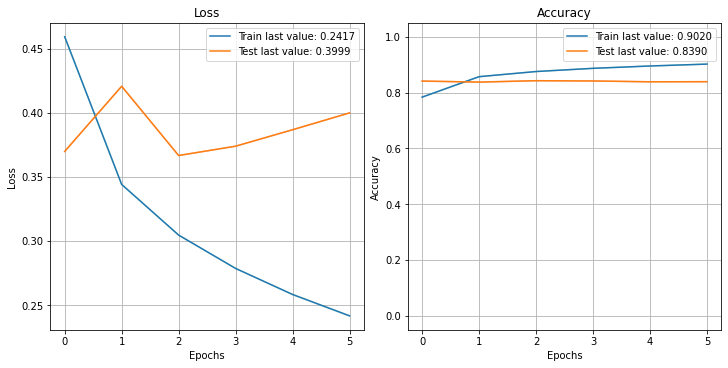

In [14]:
plot_history(history)

# Save model 

In [16]:
model.save('models/model.apr21')

INFO:tensorflow:Assets written to: models/model.apr21/assets


INFO:tensorflow:Assets written to: models/model.apr21/assets
